In [1]:
import os
import json
import copy
import pkbar
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from PIL import Image
import seaborn as sn
import rasterio as rs
from rasterio import plot

from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score, f1_score, precision_score, recall_score

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
from torchvision import datasets, transforms
from torchinfo import summary

In [3]:
dioni_data = rs.open("./HyRANK_satellite/TrainingSet/Dioni.tif").read()
dioni_labels = rs.open("./HyRANK_satellite/TrainingSet/Dioni_GT.tif").read()

loukia_data = rs.open("./HyRANK_satellite/TrainingSet/Loukia.tif").read()
loukia_labels = rs.open("./HyRANK_satellite/TrainingSet/Loukia_GT.tif").read()

C:\Users\Christos\anaconda3\envs\hyperspectral_exercise\Lib\site-packages\rasterio\__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [4]:
print(dioni_data.shape)
print(loukia_data.shape)

(176, 250, 1376)
(176, 249, 945)


## Visualize and explore input data
#### Input images are of shape (hyperspectral_band,x,y), with 176 hyperspectral bands collected from the satellite.
#### RGB bands - R:23, G:11, B:07

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


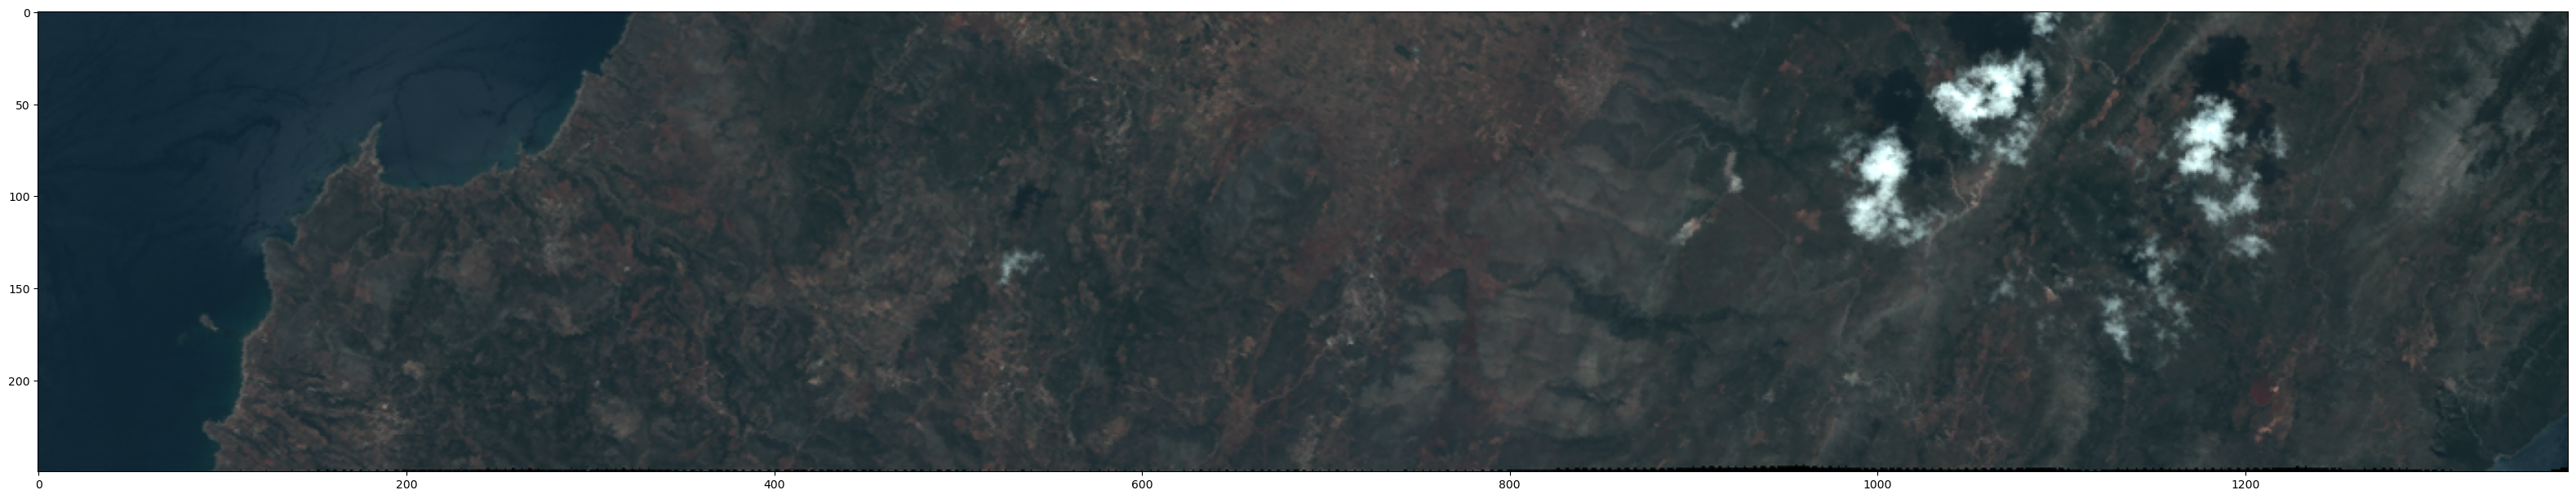

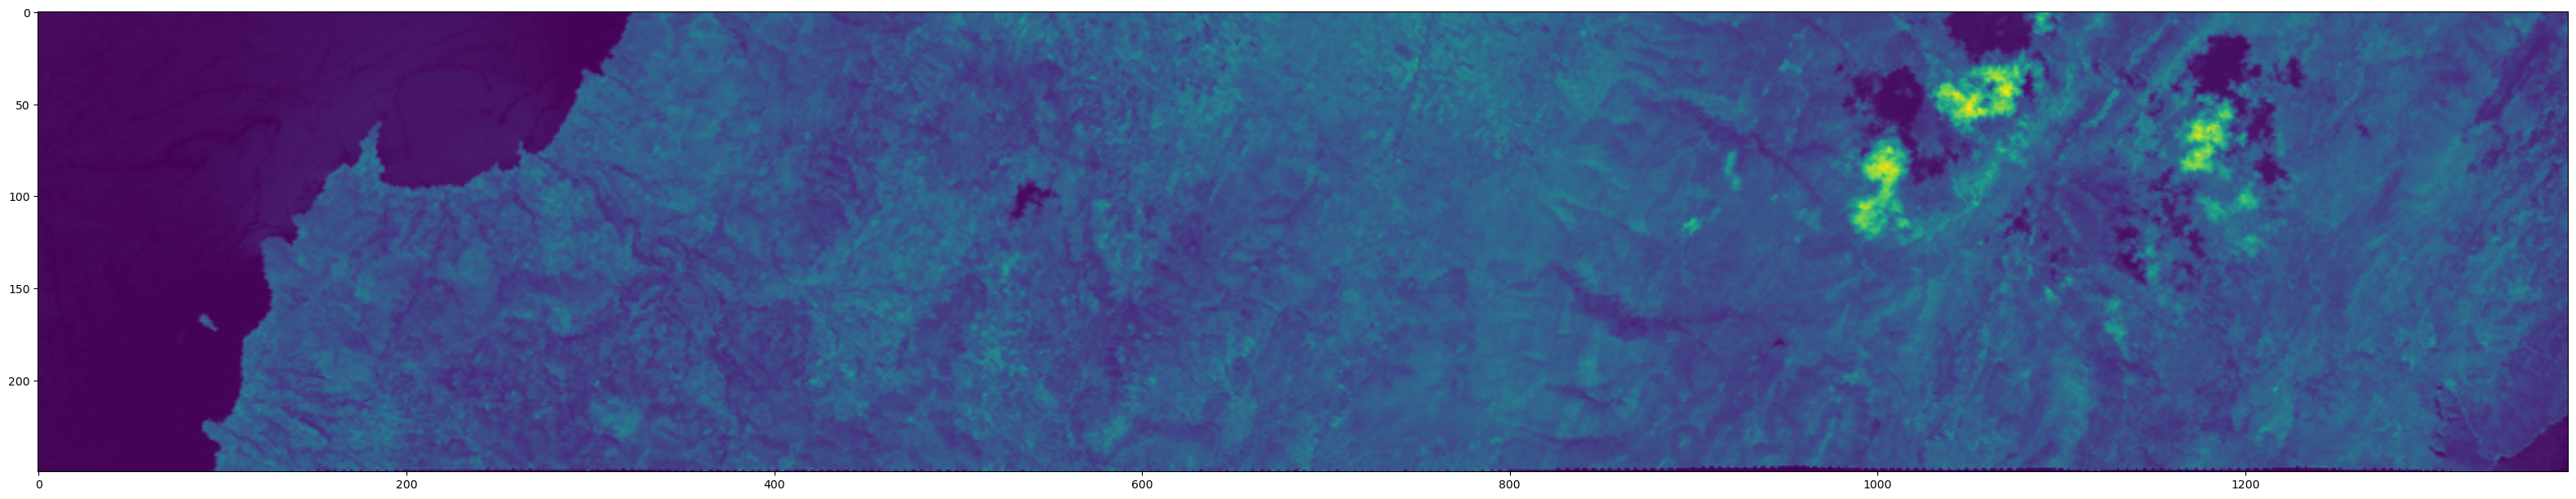

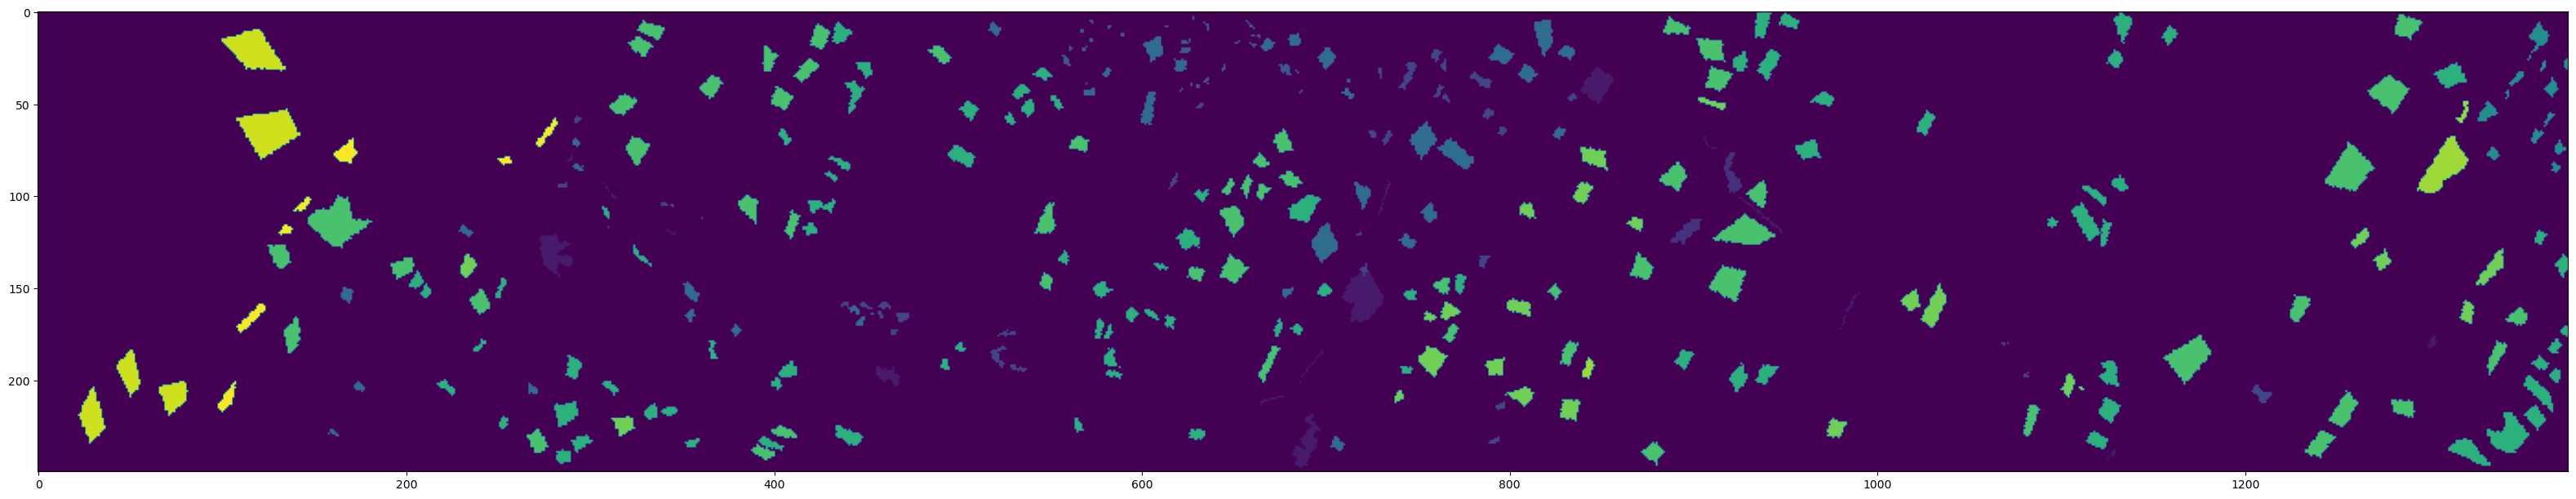

In [6]:
## Dioni image
## get the RGB bands to visualize the original image
r = np.expand_dims(dioni_data[22],axis=0)
g = np.expand_dims(dioni_data[10],axis=0)
b = np.expand_dims(dioni_data[6],axis=0)
rgb = np.concatenate((r//40,g//40,b//40))
rgb = np.transpose(rgb, (1, 2, 0))
plt.figure(figsize=(40,10))
plt.imshow(rgb)
## plt.savefig("dioni.png")
## visualize a band from Dioni
plt.figure(figsize=(40,15))
plot.show(dioni_data[123])
## visualize the labels for Dioni
plt.figure(figsize=(40,15))
plt.imshow(np.transpose(dioni_labels, (1, 2, 0)))


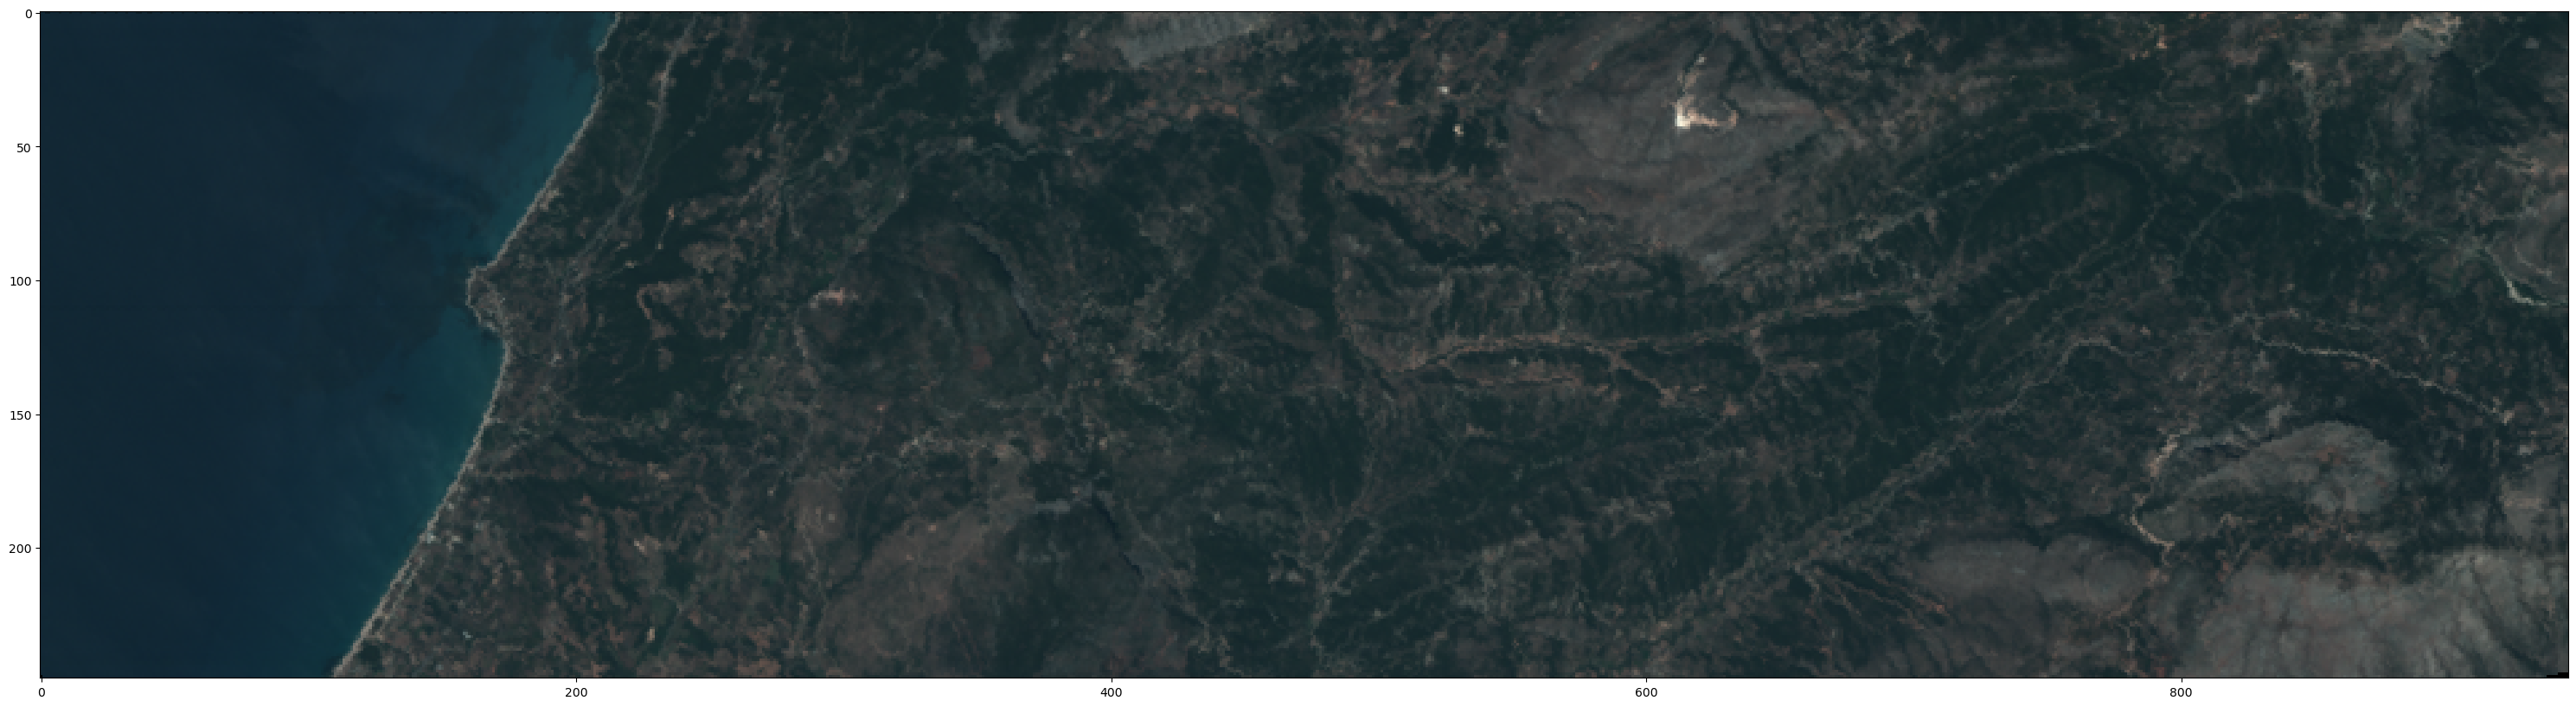

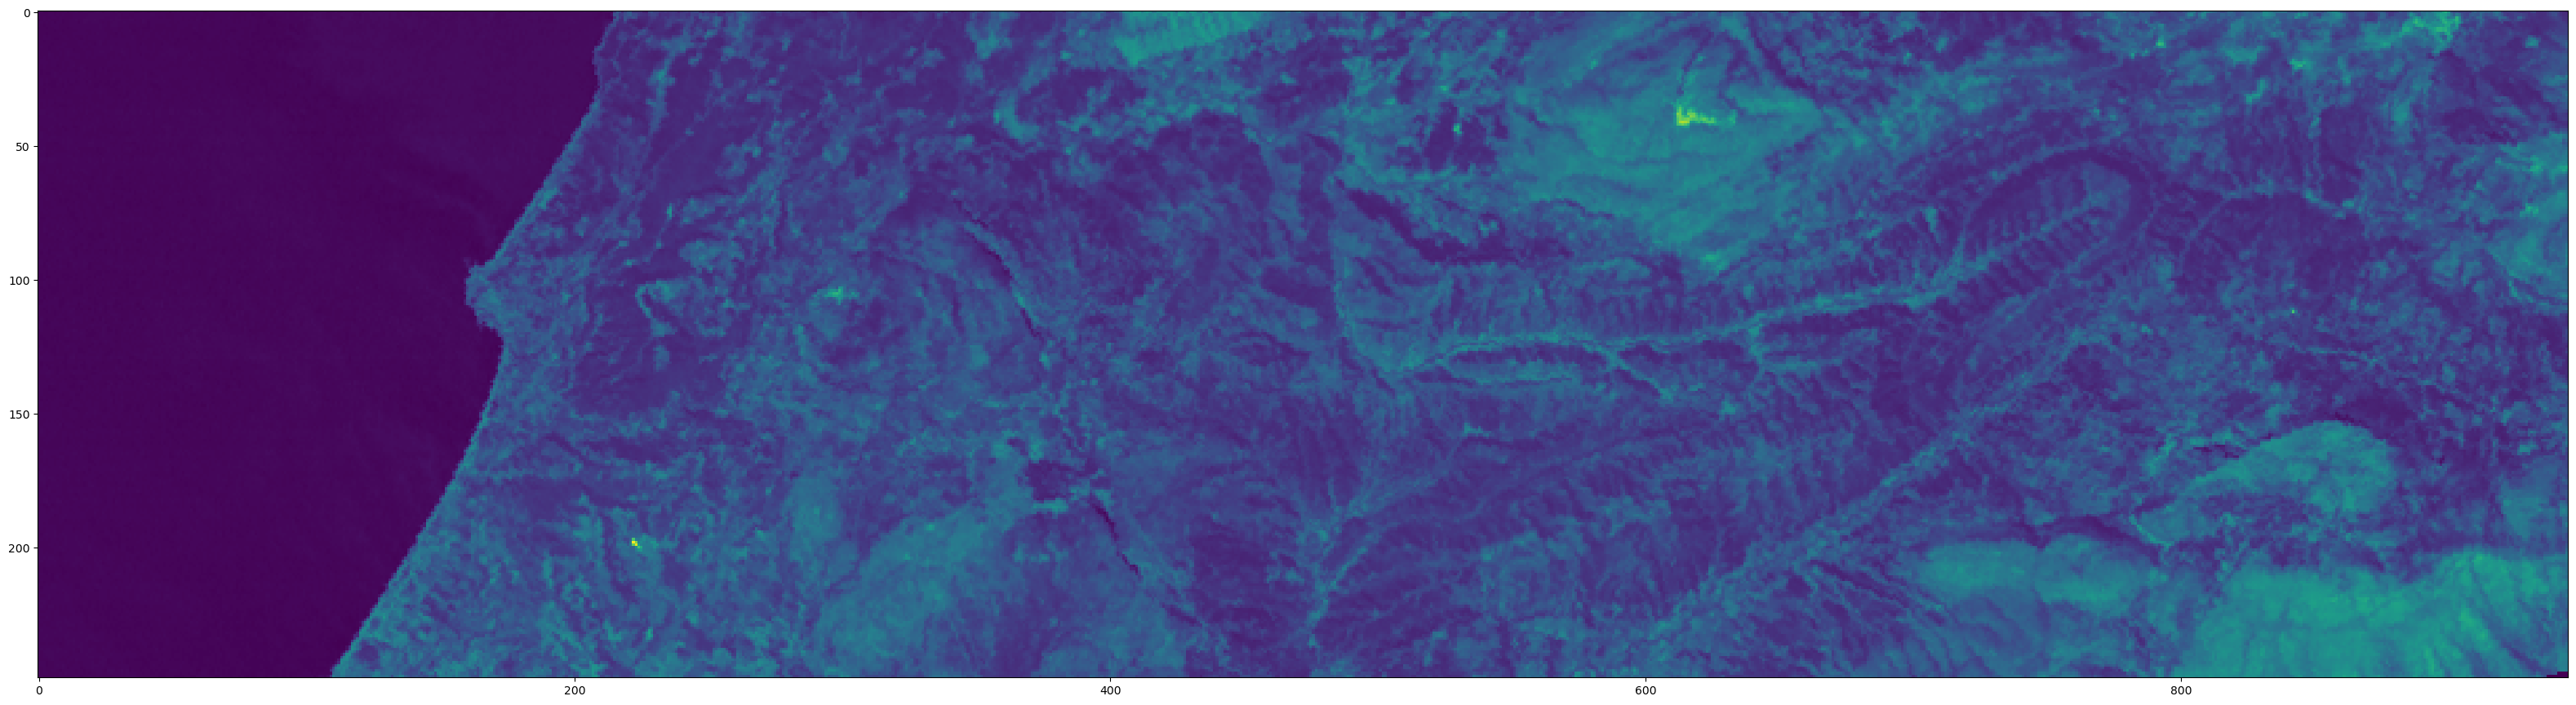

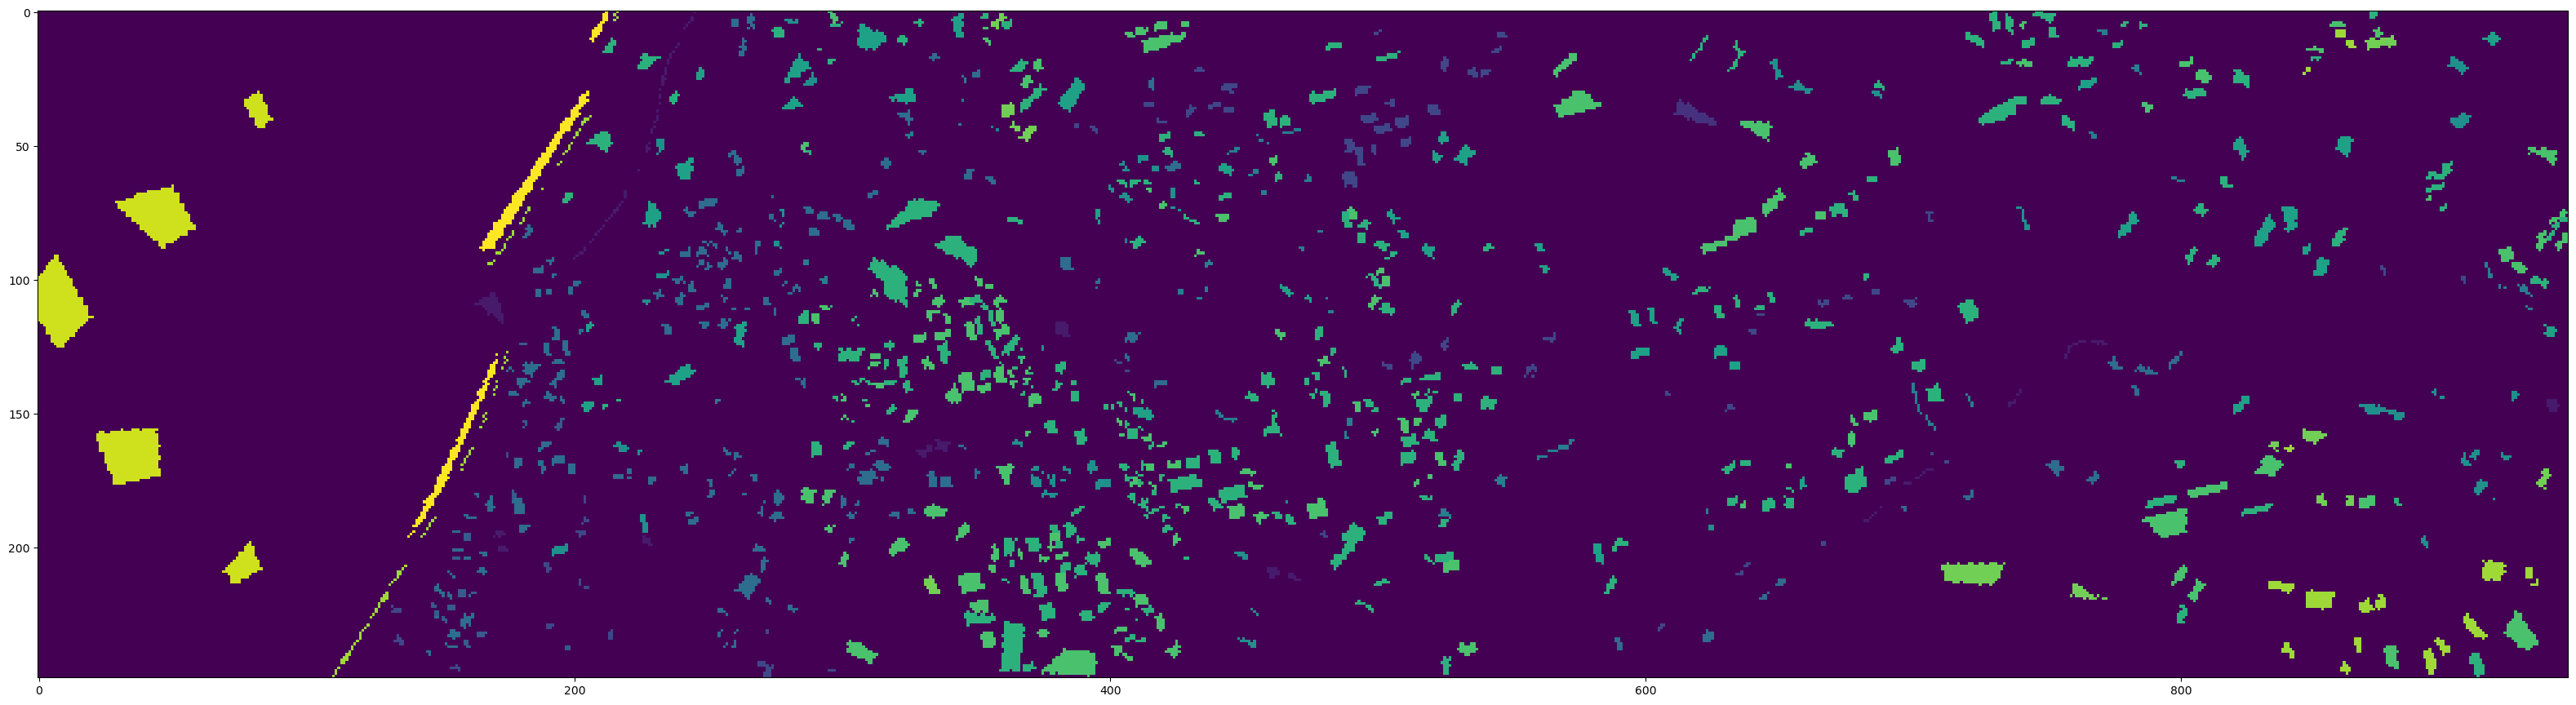

In [9]:
## loukia image
## get the RGB bands to visualize the original image
r = np.expand_dims(loukia_data[22],axis=0)
g = np.expand_dims(loukia_data[10],axis=0)
b = np.expand_dims(loukia_data[6],axis=0)
rgb = np.concatenate((r//40,g//40,b//40))
rgb = np.transpose(rgb, (1, 2, 0))
plt.figure(figsize=(40,10))
plt.imshow(rgb)
# plt.savefig("loukia.png")
## visualize a band from loukia
plt.figure(figsize=(40,15))
plot.show(loukia_data[123])
## visualize the labels for loukia
plt.figure(figsize=(40,15))
plt.imshow(np.transpose(loukia_labels, (1, 2, 0)))

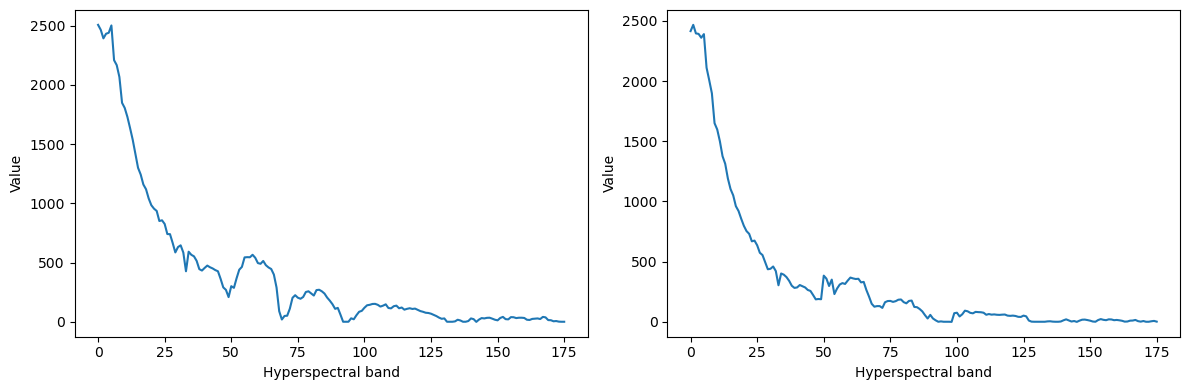

In [10]:
## Hyperspectral values (hyperspectral identities) of two pixels
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(loukia_data[:,100,140])
ax[0].set_xlabel('Hyperspectral band')
ax[0].set_ylabel('Value')

ax[1].plot(loukia_data[:,0,0])
ax[1].set_xlabel('Hyperspectral band')
ax[1].set_ylabel('Value')

plt.tight_layout()
plt.show()

In [11]:
## collect the pixel data and labels from the annotated pixels and drop the others (with annotation value 0)
dioni_pixel_data = np.reshape(dioni_data,(176,-1)).T
dioni_pixel_labels = dioni_labels.flatten()
print(dioni_pixel_labels.shape)

dioni_pixel_data_cleaned = dioni_pixel_data[dioni_pixel_labels!=0]
dioni_pixel_labels_cleaned = dioni_pixel_labels[dioni_pixel_labels!=0]
print(dioni_pixel_labels_cleaned.shape)

loukia_pixel_data = np.reshape(loukia_data,(176,-1)).T
loukia_pixel_labels = loukia_labels.flatten()
print(loukia_pixel_labels.shape)

loukia_pixel_data_cleaned = loukia_pixel_data[loukia_pixel_labels!=0]
loukia_pixel_labels_cleaned = loukia_pixel_labels[loukia_pixel_labels!=0]
print(loukia_pixel_labels_cleaned.shape)

(344000,)
(20024,)
(235305,)
(13503,)


In [12]:
## create a common dataset from both input images
merged_data = np.concatenate((dioni_pixel_data_cleaned,loukia_pixel_data_cleaned),axis=0)
merged_labels = np.concatenate((dioni_pixel_labels_cleaned,loukia_pixel_labels_cleaned),axis=0)
## train and test a Random Forest classifier on the original data with high dimensions
X_train, X_test, y_train, y_test = train_test_split(merged_data, merged_labels, test_size=0.3, random_state=42,stratify=merged_labels)
rf_clf = RandomForestClassifier(n_jobs=-1)
rf_clf.fit(X_train, y_train)
print("Random Forest accuracy without PCA: ", rf_clf.score(X_test, y_test), "%")

## use PCA to reduce the dimensionality of the 176 hyperspectral bands
pca = PCA(n_components=20)
pca.fit(merged_data)
merged_data_trans = pca.transform(merged_data)
X_train, X_test, y_train, y_test = train_test_split(merged_data_trans, merged_labels, test_size=0.3, random_state=42,stratify=merged_labels)
rf_clf = RandomForestClassifier(n_jobs=-1)
rf_clf.fit(X_train, y_train)
print("Random Forest accuracy with PCA: ", rf_clf.score(X_test, y_test), "%")

Random Forest accuracy without PCA:  0.9068495874341386 %
Random Forest accuracy with PCA:  0.9165921065712297 %


## Define training/validation dataset creator, dataloader and the 3D CNN architecture

In [14]:
## create dataloader class
class my_Dataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        # Return the length of the dataset
        return len(self.data)

    def __getitem__(self, idx):
        # Return the observation based on an index. Ex. dataset[0] will return the first element from the dataset, in this case the image and the label.
        if torch.is_tensor(idx):
            idx = idx.tolist()

        patch = self.data[idx]
        patch = np.expand_dims(patch,axis=0)
        label = self.labels[idx] -1

        patch = (patch - means) / stds
        patch = torch.tensor(patch).type(torch.FloatTensor)
        label = torch.tensor(label).type(torch.LongTensor)
        
        if self.transform:
            patch = self.transform(patch)      
    
        return (patch, label)

In [15]:
## create the labelled dataset construction function
def create_dataset(data_list,labels_list,patch_size):
    x_patches = []
    y_patches = []
    
    for i in range(len(data_list)):
        
        n,x,y = data_list[i].shape
        x_patch = patch_size
        y_patch = patch_size
        x_padding = x_patch//3+1
        y_padding = y_patch//3+1

        x = torch.from_numpy(np.pad(data_list[i],[(0,0),(x_padding, x_padding), (y_padding, y_padding)], mode='constant'))
        y = torch.from_numpy(labels_list[i])

        
        # unfold(dimension, square size, overlapping)
        x = x.unfold(1, x_patch, 1).unfold(2, x_patch, 1)
        x = x.permute(1,2,0,3,4)
        x = x.contiguous().view(-1, 176, x_patch, x_patch)
        
        y = torch.flatten(y)
        
        x = np.delete(x,np.where(y==0),axis=0)
        y = np.delete(y,np.where(y==0),axis=0)
        
        x_patches.append(x)
        y_patches.append(y)
             
    return np.concatenate((x_patches[0],x_patches[1]),axis=0),np.concatenate((y_patches[0],y_patches[1]))

In [16]:
## calculate mean and std of the data
data_list = [dioni_data, loukia_data]
labels_list = [dioni_labels, loukia_labels]
x,y = create_dataset(data_list, labels_list, 5)

means = list(np.mean(x,axis=(0,2,3)))
stds = list(np.std(x,axis=(0,2,3)))
means = np.expand_dims(means,axis=0)
means = np.expand_dims(means,axis=2)
means = np.expand_dims(means,axis=3)

stds = np.expand_dims(stds,axis=0)
stds = np.expand_dims(stds,axis=2)
stds = np.expand_dims(stds,axis=3)

In [17]:
# training function
def train_val(model, epochs = 15):
    steps = 0
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    train_loss = 0
    train_accuracy = 0
    for epoch in range(epochs):
        kbar = pkbar.Kbar(target=len(train_loader), epoch=epoch, num_epochs=epochs, width=8, always_stateful=False)
        batch_num = 0
        for inputs, labels in train_loader:          
            inputs, labels = inputs.to(device), labels.to(device)
            
            logps = model.forward(inputs)
            loss = criterion(logps, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            # accuracy
            ps = torch.exp(logps)
            top_p, top_class = ps.topk(1, dim=1)
            equals = (top_class) == labels.view(*top_class.shape)
            train_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

            kbar.update(batch_num, values=[("Loss", loss), ("Train accuracy", torch.mean(equals.type(torch.FloatTensor)).item())])

            batch_num += 1

        model.eval()
        val_loss = 0
        val_accuracy = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device, dtype=torch.float), labels.to(device, dtype=torch.long)
                logps = model.forward(inputs)

                batch_loss = criterion(logps, labels)

                val_loss += batch_loss.item()

                # Calculate accuracy
                ps = torch.exp(logps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                val_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()


        kbar.add(1, values=[("Val loss", val_loss/len(val_loader)), ("Val accuracy", val_accuracy/len(val_loader))])

        train_losses.append(train_loss/len(train_loader))
        val_losses.append(val_loss/len(val_loader))
        train_accuracies.append(train_accuracy/len(train_loader))
        val_accuracies.append(val_accuracy/len(val_loader))

        train_loss = 0
        train_accuracy = 0
        model.train()

    plt.figure(figsize=(14,7))
    plt.plot(train_losses, label='Training loss')
    plt.plot(val_losses, label='Validation loss')
    plt.legend(frameon=False)

    plt.figure(figsize=(14,7))
    plt.plot(train_accuracies, label='Training accuracy')
    plt.plot(val_accuracies, label='Validation accuracy')
    plt.legend(frameon=False)
    
    return

In [18]:
## define the architecture of the 3D Conv NN
class my_3D_net(nn.Module):
    def __init__(self):
        super().__init__()        
        
        self.conv1 = nn.Conv3d(1, 16, kernel_size=(32,3,3), stride=1,padding=(0,1,1))
        self.conv2 = nn.Conv3d(16, 32, kernel_size=(32,3,3), stride=1,padding=(0,1,1))
        self.conv3 = nn.Conv3d(32, 64, kernel_size=(32,3,3), stride=1,padding=(0,1,1))
        
        self.max1 = nn.MaxPool3d(kernel_size=(1, 2, 2))
        self.max2 = nn.MaxPool3d(kernel_size=(1, 2, 2))
    
        self.dropout = nn.Dropout(0.2)
           
        self.fc1 = nn.Linear(32 * 114 * 1, 14)
    
    def forward(self, x):
        # encoder
        x = self.max1(F.relu(self.conv1(x)))
        x = self.max2(F.relu(self.conv2(x)))

        # classifier        
        x = x.view(-1,  32 * 114 * 1 * 1)
        x = self.dropout(x)
        x = F.log_softmax(self.fc1(x), dim=1)
        return x
    
summary(my_3D_net(),(16,1,176,5,5))

Layer (type:depth-idx)                   Output Shape              Param #
my_3D_net                                [16, 14]                  589,888
├─Conv3d: 1-1                            [16, 16, 145, 5, 5]       4,624
├─MaxPool3d: 1-2                         [16, 16, 145, 2, 2]       --
├─Conv3d: 1-3                            [16, 32, 114, 2, 2]       147,488
├─MaxPool3d: 1-4                         [16, 32, 114, 1, 1]       --
├─Dropout: 1-5                           [16, 3648]                --
├─Linear: 1-6                            [16, 14]                  51,086
Total params: 793,086
Trainable params: 793,086
Non-trainable params: 0
Total mult-adds (Units.GIGABYTES): 1.35
Input size (MB): 0.28
Forward/backward pass size (MB): 9.29
Params size (MB): 0.81
Estimated Total Size (MB): 10.39

In [19]:
## create the datasets for training-validation-test
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=42,stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.50, random_state=42,stratify=y_test)

batch_size = 16
train_dataset = my_Dataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,shuffle=True)

val_dataset = my_Dataset(X_val, y_val)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

test_dataset = my_Dataset(X_test, y_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,shuffle=True)

cuda
Epoch: 1/100
1467/1467 [========] - 38s 26ms/step - Loss: 0.6943 - Train accuracy: 0.7620 - Val loss: 0.4516 - Val accuracy: 0.8359
Epoch: 2/100
1467/1467 [========] - 38s 26ms/step - Loss: 0.4521 - Train accuracy: 0.8408 - Val loss: 0.3173 - Val accuracy: 0.8889
Epoch: 3/100
1467/1467 [========] - 38s 26ms/step - Loss: 0.3957 - Train accuracy: 0.8595 - Val loss: 0.3085 - Val accuracy: 0.8881
Epoch: 4/100
1467/1467 [========] - 38s 26ms/step - Loss: 0.3553 - Train accuracy: 0.8734 - Val loss: 0.3011 - Val accuracy: 0.8940
Epoch: 5/100
1467/1467 [========] - 38s 26ms/step - Loss: 0.3174 - Train accuracy: 0.8844 - Val loss: 0.3053 - Val accuracy: 0.8855
Epoch: 6/100
1467/1467 [========] - 38s 26ms/step - Loss: 0.3223 - Train accuracy: 0.8853 - Val loss: 0.2512 - Val accuracy: 0.9060
Epoch: 7/100
1467/1467 [========] - 37s 26ms/step - Loss: 0.2804 - Train accuracy: 0.8981 - Val loss: 0.2454 - Val accuracy: 0.9060
Epoch: 8/100
1467/1467 [========] - 37s 25ms/step - Loss: 0.2656 - Trai

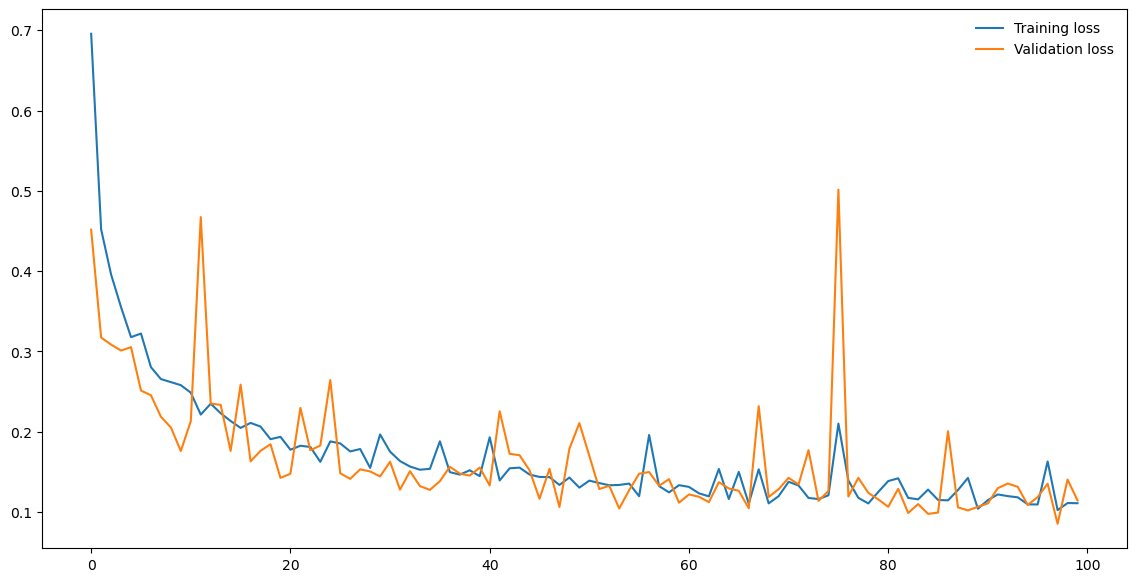

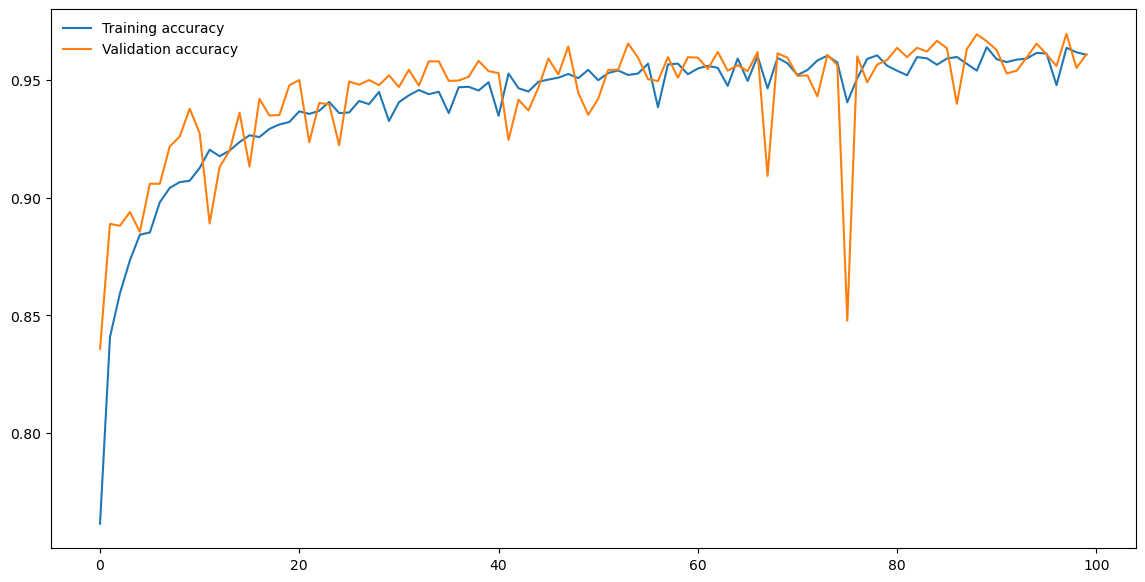

In [20]:
## setup and train the model
my_model = my_3D_net()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
criterion = nn.NLLLoss(ignore_index=-1)

optimizer = optim.Adam(my_model.parameters(), lr=0.001,weight_decay=0.001)

my_model.to(device)

train_val(my_model, 100)

In [21]:
# test and results function
label_names = ["DenseUrban",
               "MineralExtr",
               "NonIrrigated",
               "Fruit",
               "Olive",
               "BroadForest",
               "ConiferousForest",
               "MixedForest",
               "DenseScleroph",
               "SparceScleroph",
               "SparcelyVeget",
               "RocksSand",
               "Water",
               "CoastalWater"]

def test_results(model):
    tot_test_loss = 0
    test_correct = 0  
    all_predictions = []
    all_labels = []


    with torch.no_grad():
        model.eval()
        for inputs, labels in test_loader:

            inputs, labels = inputs.to(device), labels.to(device)

            log_ps = model(inputs)
            loss = criterion(log_ps, labels)
            tot_test_loss += loss.item()

            ps = torch.exp(log_ps).cpu()
            top_p, top_class = ps.topk(1, dim=1)
            top_p, top_class =top_p.cpu(), top_class.cpu()
            all_predictions.append(list(top_class.numpy().squeeze()))
            all_labels.append(list(labels.cpu().cpu().numpy().squeeze()))
            equals = top_class == labels.cpu().view(*top_class.shape)
            test_correct += equals.sum().item()

            test_loss = tot_test_loss / len(test_loader.dataset)

    print("Test Loss: {:.3f}.. ".format(test_loss),"Test Accuracy: {:.3f}".format(test_correct / len(test_loader.dataset)))

    pred_list = [item for sublist in all_predictions for item in sublist]
    labels_list = [item for sublist in all_labels for item in sublist]

    prec, rec, f1, sup = precision_recall_fscore_support(labels_list, pred_list)

    # print("Precision :", prec)
    # print("Recall :", rec)
    # print("F1 Score :", f1)



    prec_weighted, rec_weighted, f1_weighted, sup_weighted = precision_recall_fscore_support(labels_list, pred_list,average='weighted')

    print("Precision weighted:", prec_weighted)
    print("Recall weighted:", rec_weighted)
    print("F1 Score weighted:", f1_weighted)

    cm=confusion_matrix(labels_list,pred_list)

    df_cm = pd.DataFrame(cm, index = range(1,15),
                      columns = range(1,15))
    plt.figure(figsize = (16,13)) 
    sn.heatmap(df_cm, annot=True,fmt='d',yticklabels=label_names,xticklabels=label_names)
    t = plt.yticks(rotation=0)
    t = plt.xticks(rotation=45)

    return

Test Loss: 0.007..  Test Accuracy: 0.963
Precision weighted: 0.9638553482311146
Recall weighted: 0.963220675944334
F1 Score weighted: 0.9628987074511156


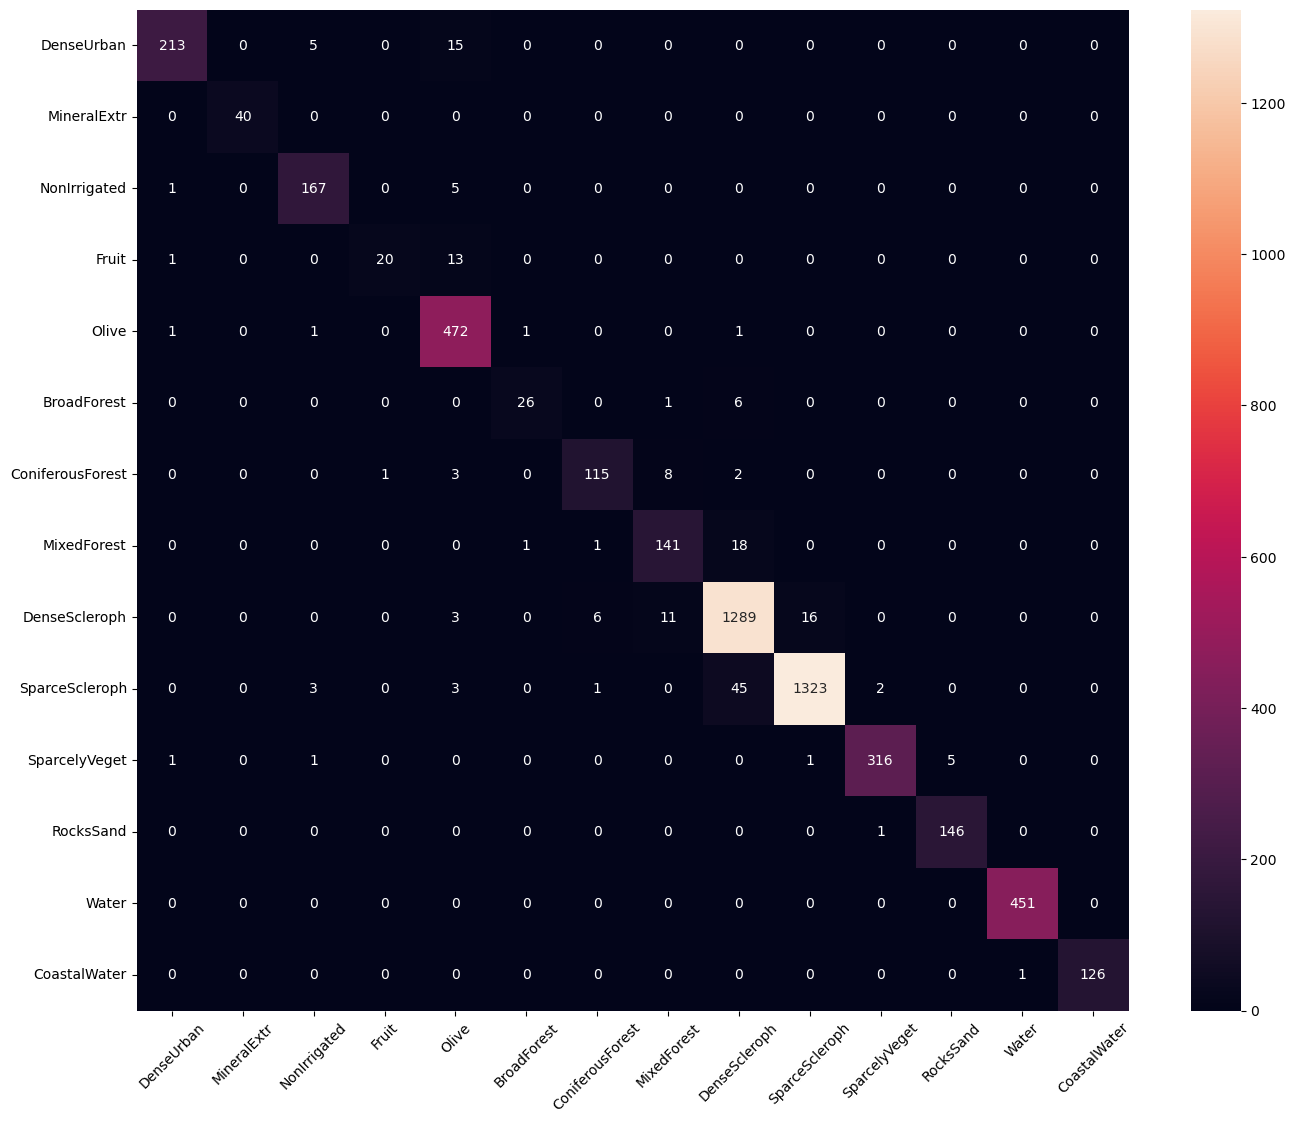

In [22]:
test_results(my_model)

## Create test dataset, dataloader and test the trained model on the provided test images


In [24]:
## select which test image is going to be processed for final delivery
selected_set = 2

test_data_paths = [
    "./HyRANK_satellite/ValidationSet/Erato.tif",
    "./HyRANK_satellite/ValidationSet/Kirki.tif",
    "./HyRANK_satellite/ValidationSet/Nefeli.tif"
]

test_names = [
    "erato",
    "kirki",
    "nefeli"
]


data = rs.open(test_data_paths[selected_set]).read()
shape = data.shape

C:\Users\Christos\anaconda3\envs\hyperspectral_exercise\Lib\site-packages\rasterio\__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [25]:
## create a new dataloader for the test images without the labels info
class my_test_Dataset(Dataset):
    def __init__(self, data, transform=None):     
        self.data = data
        self.transform = transform
        
    def __len__(self):
        # Return the length of the dataset
        return len(self.data)

    def __getitem__(self, idx):
        # Return the observation based on an index. Ex. dataset[0] will return the first element from the dataset, in this case the image and the label.
        if torch.is_tensor(idx):
            idx = idx.tolist()

        patch = self.data[idx]
        patch = np.expand_dims(patch,axis=0)

        if self.transform:
            patch = self.transform(patch)
            
        patch = (patch - means) / stds
        
        patch = torch.tensor(patch).type(torch.FloatTensor)
        
        return (patch)

In [26]:
## create the unlabelled dataset construction function 
def create_test_dataset(data,patch_size):
    
    n,x,y = data.shape
    x_patch = patch_size
    y_patch = patch_size
    x_padding = x_patch//3+1
    y_padding = y_patch//3+1

    data = torch.from_numpy(np.pad(data,[(0,0),(x_padding, x_padding), (y_padding, y_padding)], mode='constant'))

    # unfold(dimension, square size, overlapping)
    data = data.unfold(1, x_patch, 1).unfold(2, x_patch, 1)
    data = data.permute(1,2,0,3,4)
    data = data.contiguous().view(-1, 176, x_patch, x_patch)

    return data

In [27]:
# test and results function
def test_results(model):
    all_predictions = []

    i=0
    with torch.no_grad():
        model.eval()
        for inputs in test_loader:

            inputs = inputs.to(device)

            log_ps = model(inputs)

            ps = torch.exp(log_ps)
            top_p, top_class = ps.topk(1, dim=1)
            top_p, top_class =top_p, top_class
            all_predictions.append(top_class.cpu().numpy())
            i+=1
            
    return all_predictions

In [28]:
## create test dataset, define batch size and initiate dataloader
x = create_test_dataset(data, 5).type(torch.HalfTensor) 
batch_size = 64
test_dataset = my_test_Dataset(x)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

res = test_results(my_model)

(192228, 1)


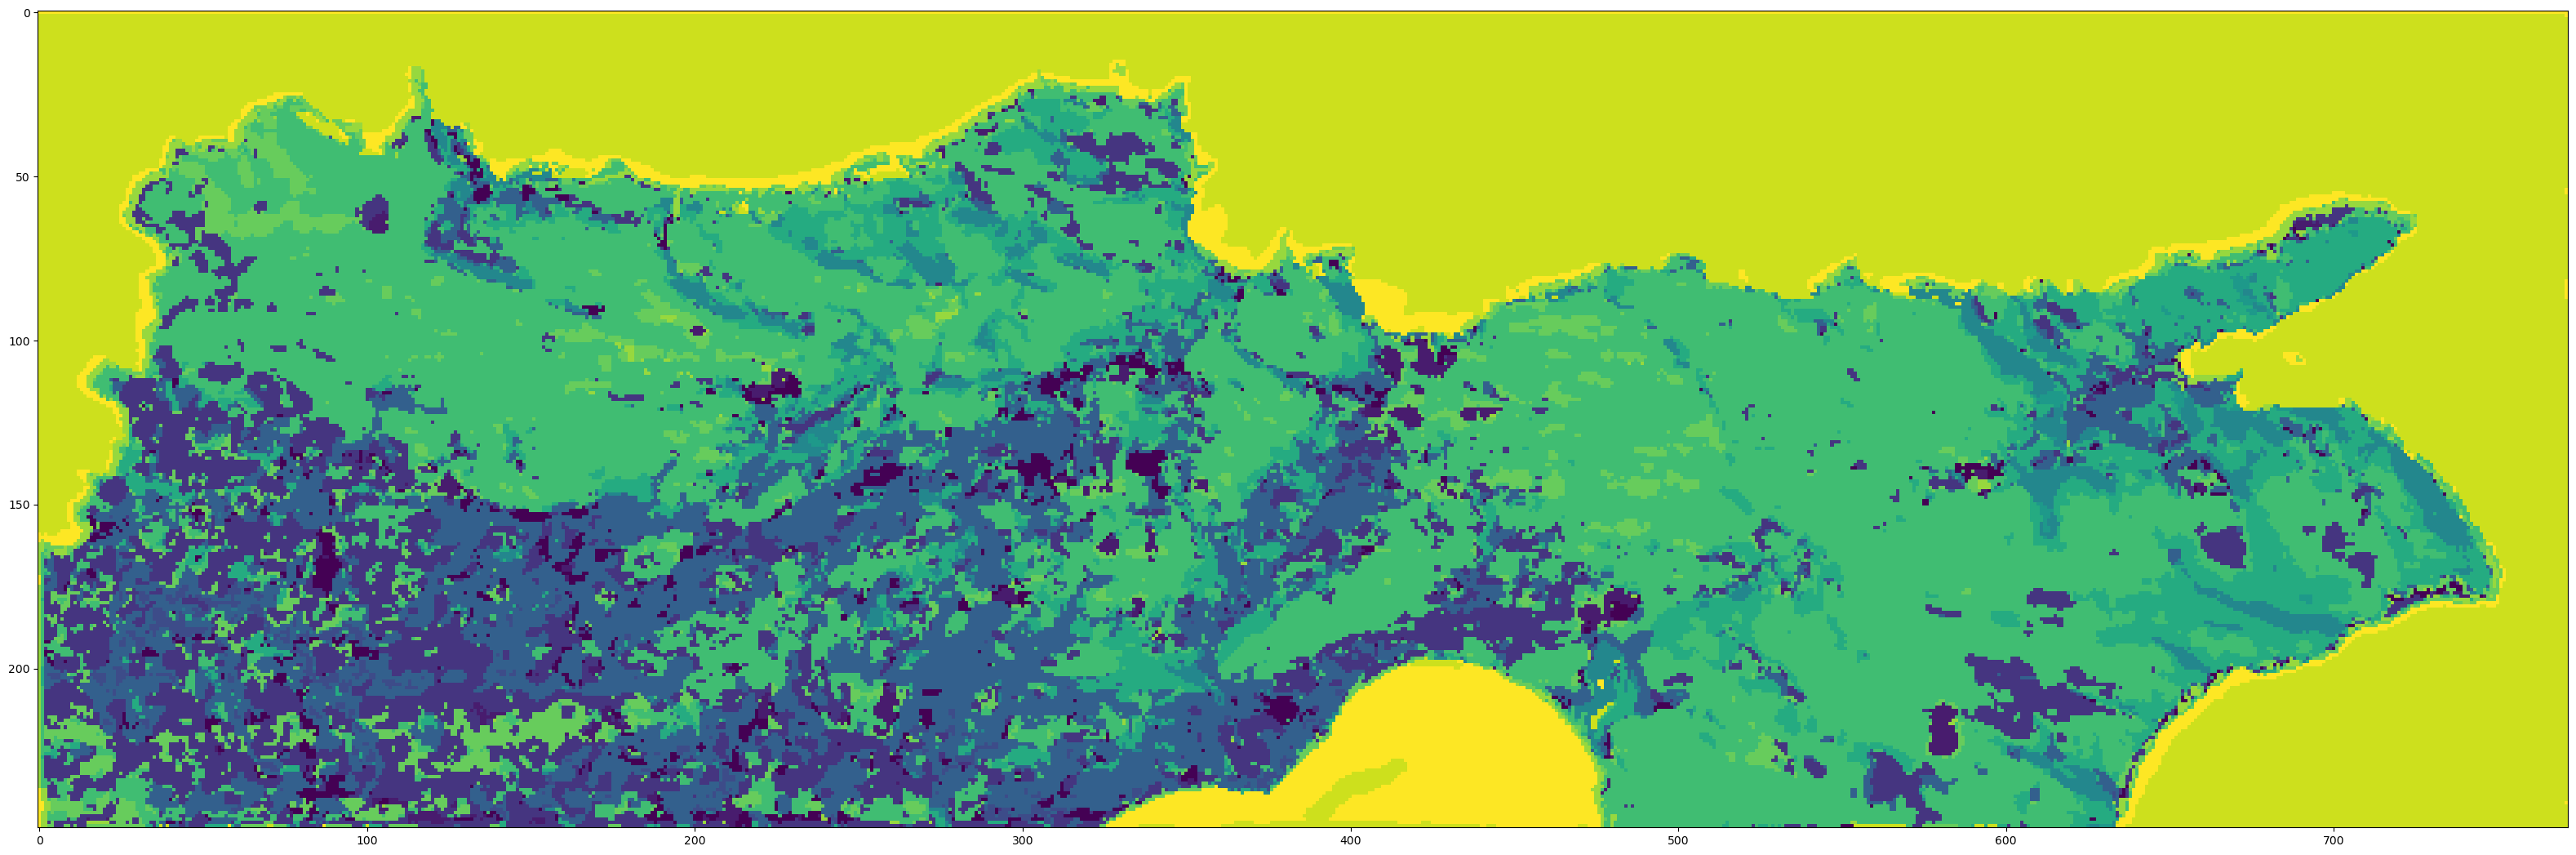

In [29]:
## collect, format and save the results for the selected test image
collected_results = np.concatenate(res)
print(collected_results.shape)
image = np.reshape(collected_results,shape[1:]) + 1

plt.figure(figsize=(40,15))
plot.show(image)
# plt.savefig(test_names[selected_set] + "_results.png")

im = Image.fromarray(image.astype('uint8'))
# im.save(test_names[selected_set] + "_results.tif")